# Neuromatch Academy: Week 3, Day 4, Tutorial 2
# Deep Learning: Encoding Neural Responses

**Content creators**: Jorge A. Menendez, Carsen Stringer 

**Content reviewers**: Roozbeh Farhoodi, Ella Batty, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom





---
#Tutorial Objectives

In this tutorial, we'll use deep learning to build an encoding model from stimuli to neural activity. Specifically, we'll be looking at the activity of ~20,000 neurons in mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). 

Because the stimuli are 1D and the neurons respond with smooth tuning curves, we will model the neural responses as a 1D convolutional operation on the stimulus. 

In this tutorial, we will 
* Understand the basics of convolution
* Build and train a convolutional neural network to predict neural responses using PyTorch
* Visualize and analyze its internal representations

---
# Setup


In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt

In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Helper Functions
# Some helper functions
def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor


def plot_tuning(ax, stimuli, respi_train, respi_test, neuron_index, linewidth=2):
  """Plot the tuning curve of a neuron"""

  ax.plot(stimuli, respi_train, 'y', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.plot(stimuli, respi_test, 'm', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.set_title('neuron %i' % neuron_index)
  ax.set_xlabel('stimulus orientation ($^o$)')
  ax.set_ylabel('neural response')
  ax.set_xticks(np.linspace(0, 360, 5))
  ax.set_ylim([-0.5, 2.4])


# from bayes day!
def my_gaussian(x_points, mu, sigma):
  """
  Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`

  Args:
    x_points (numpy array of floats): points at which the gaussian is evaluated
    mu (scalar): mean of the Gaussian
    sigma (scalar): std of the gaussian

  Returns:
    (numpy array of floats) : un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)
  px = px / px.sum()
  return px


def plot_conv(pad, stimulus, filter, conv_out):
  """ plot 1D convolution """
  # plot stimulus
  ax = fig.add_subplot(1,3,1)
  ax.plot(np.arange(0, 360), stimulus, 'k')
  ax.set_title('stimulus')
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('stimulus')

  # plot convolutional filter
  ax = fig.add_subplot(1,3,2)
  ax.plot(np.arange(-pad, pad), filter)
  ax.set_xlabel('orientation ($^o$)')
  ax.set_ylabel('magnitude')
  ax.set_title('convolutional filter')

  # plot convolutional output
  ax = fig.add_subplot(1,3,3)
  n_units = (~np.isnan(conv_out)).sum()
  ax.scatter(np.arange(0,n_units),
             conv_out[~np.isnan(conv_out)], s=30,
             cmap='hsv', c=np.arange(0,n_units))
  ax.set_xlabel('convolutional unit')
  ax.set_ylabel('activation')
  ax.set_title('activations of\nconvolutional units')


def plot_example_activations(act):
  """ plot activations act and corresponding stimulus
  Args:
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
  """
  ns = [10,25,40]
  fig, axs = plt.subplots(1,3,figsize=(12,4))
  for k, (n, ax) in enumerate(zip(ns, axs.flatten())):
    ax.plot(n * np.ones(2), [act.min()*1.15, act.max()*1.15], 'k', linewidth=4)
    ax.plot(act[n].T, '.', linewidth=2)
    ax.set_xlabel('convolutional unit')
    ax.set_ylabel('activation')
    ax.set_title('stim id %d'%n)
    leg = ['chan%d'%i for i in range(act.shape[1])]
    leg.insert(0, 'stim')
    n_units = act.shape[0]
    for k,s in enumerate(leg):
      if k==0:
        ax.text(((n+15)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='k', ha='center')
      else:
        ax.text(((n+15)%n_units)/n_units, .9-k*.1, s, transform=ax.transAxes, color='C%d'%(k-1), ha='center')


def train(net, custom_loss, train_data, train_labels,
          test_data=None, test_labels=None,
          learning_rate=10, n_iter=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    custom_loss: loss function for network
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    test_data: test data (n_train x input features)
    test_labels: test labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty

  Returns:
    train_loss: training loss across iterations
    test_loss: testing loss across iterations

  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5) # Initialize PyTorch SGD optimizer
  train_loss = np.nan * np.zeros(n_iter)  # Placeholder for train loss
  test_loss = np.nan * np.zeros(n_iter)  # Placeholder for test loss

  # Loop over epochs
  for i in range(n_iter):
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    if L2_penalty>0 or L1_penalty>0:
      weights = net.out_layer.weight
      loss = custom_loss(y_pred, train_labels, weights, L2_penalty, L1_penalty)
    else:
      loss = custom_loss(y_pred, train_labels)

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    train_loss[i] = loss.item()  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if (i+1) % (n_iter // 10) == 0 or i==0:
      if test_data is not None and test_labels is not None:
        y_pred = net(test_data)
        if L2_penalty>0 or L1_penalty>0:
          loss = custom_loss(y_pred, test_labels, weights, L2_penalty, L1_penalty)
        else:
          loss = custom_loss(y_pred, test_labels)
        test_loss[i] = loss.item()
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f} | test loss: {test_loss[i]:.4f}')
      else:
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f}')

  return train_loss, test_loss


def plot_pred_weights(y_pred, y_train, y_test, weights):
  """ plot example neural response prediction + weights """
  fig = plt.figure(figsize=(12,4))
  ax =fig.add_subplot(1,3,1)
  ax.plot(y_train, 'y', linewidth=1)
  ax.plot(y_test, 'm', linewidth=1)
  ax.plot(y_pred, 'g', linestyle='-', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')
  ax.text(0.1, 1.0, 'train', color='y', transform=ax.transAxes)
  ax.text(0.1, 0.9, 'test', color='m', transform=ax.transAxes)
  ax.text(0.1, 0.8, 'pred', color='g', transform=ax.transAxes)

  ax=fig.add_subplot(1,3,2)
  ax.plot(y_train, y_train, 'k', lw=1)
  ax.scatter(y_train, y_pred, s=8, color='y')
  ax.scatter(y_test, y_pred, s=8, color='m')
  ax.set_xlabel('neural response')
  ax.set_ylabel('predicted response', color='g')
  ax.text(0.1, 1.0, 'train', color='y', transform=ax.transAxes)
  ax.text(0.1, 0.9, 'test', color='m', transform=ax.transAxes)
  plt.axis('square')

  ### plot weights of fully-connected layer for first 300 neurons
  plt.subplot(1,3,3)
  plt.imshow(weights, aspect='auto', cmap='bwr', vmin=-0.01,vmax=0.01)
  plt.title('out_layer weights')
  plt.ylabel('neurons')
  plt.xlabel('convolutional units')
  plt.colorbar()
  plt.tight_layout()
  plt.show()


def plot_prediction(ax, y_pred, y_test):
  """ plot prediction of neural response + test neural response """
  ax.plot(y_test,color='m')
  ax.plot(y_pred, 'g', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')


def plot_training_curves(train_loss, test_loss):
  f, ax = plt.subplots()
  ax.plot(train_loss, 'y', label="Train loss")
  ax.plot(test_loss, '.', markersize=10, color='m', label="Test loss")
  ax.set(xlabel="Gradient descent iteration", ylabel="Mean squared error")
  plt.legend()

# Summary of Helper functions:

*load_data*: Load mouse V1 data from Stringer et al. (2019)

    These data comprise time-averaged responses of ~20,000 neurons
    to ~4,000 stimulus gratings of different orientations, recorded
    through Calcium imaginge. The responses have been normalized by
    spontanous levels of activity and then z-scored over stimuli, so
    expect negative numbers. They have also been binned and averaged
    to each degree of orientation.

    This function returns the relevant data (neural responses and
    stimulus orientations) in a torch.Tensor of data type torch.float32
    in order to match the default data type for nn.Parameters in
    Google Colab.

    This function will actually average responses to stimuli with orientations
    falling within bins specified by the bin_width argument. This helps
    produce individual neural "responses" with smoother and more
    interpretable tuning curves.

*plot_tuning(ax, stimuli, respi_train, respi_test, neuron_index, linewidth=2)*: "Plot the tuning curve of a neuron i.e., stimulus orientation (xaxis) vs neural response (yaxis)

*my_gaussian*: Returns normalized Gaussian estimated at points `x_points`, with parameters: mean `mu` and std `sigma`

*plot_conv(pad, stimulus, filter, conv_out)*: plot 1D convolution
- Stimulus: orientation (xaxis) vs stimulus (yaxis)
- Convolution filter: orientation (xaxis) vs magnitude (yaxis)
- Convolutional unit output/ Activations of convolution units: convolution unit (xaxis) vs activation (yaxis)

*plot_example_activations(act)*: plot activations act and corresponding stimulus

*train(net, custom_loss, train_data, train_labels,
          test_data=None, test_labels=None,
          learning_rate=10, n_iter=500, L2_penalty=0., L1_penalty=0.)*: Run gradient descent for network without batches; loop over epochs - forward pass / update parameters / backward progress / track progress

*plot_pred_weights(y_pred, y_train, y_test, weights)*: plot example neural response prediction + weights; 
- stimulus bin (xaxis) vs response (yaxis)
- neural response (xaxis) vs predicted response (yaxis)
- for out_layer weights, neurons (yaxis) vs convolutional units (xaxis)

*plot_prediction(ax, y_pred, y_test)*: plot prediction of neural response + test neural response

*plot_training_curves(train_loss, test_loss)*: gradient descent iteration (xaxis) vs mean squared error (yaxis)

---
# Section 1: Neural Tuning Curves

In the next cell, we plot the turning curves of a random subset of neurons. We have binned the stimuli orientations more than in Tutorial 1. 

Rerun the cell to look at different example neurons and observe the diversity of tuning curves in the population. How can we fit these neural responses with an encoding model?




In [ ]:
#@title
#@markdown Execute this cell to load data and plot neural tuning curves

### Load data and bin at 8 degrees
# responses are split into test and train
resp_train, resp_test, stimuli = load_data_split()
n_stimuli, n_neurons = resp_train.shape
print('resp_train contains averaged responses of %i neurons to %i binned stimuli' % (n_neurons, n_stimuli))
#print(resp_train.shape)

# also make stimuli into array of 0's and 1's
n_bins = len(stimuli)
stim_binary = torch.eye(n_bins, dtype=torch.float32)

# Visualize tuning curves
fig, axs = plt.subplots(3, 5, figsize=(15,7))
for k, ax in enumerate(axs.flatten()):
  neuron_index = np.random.choice(n_neurons)  # pick random neuron
  plot_tuning(ax, stimuli, resp_train[:, neuron_index], resp_test[:, neuron_index], neuron_index, linewidth=2)
  if k==0:
    ax.text(1.0, 0.9, 'train', color='y', transform=ax.transAxes)
    ax.text(1.0, 0.65, 'test', color='m', transform=ax.transAxes)
fig.tight_layout()
plt.show()

---
# Section 2: Introduction to convolutions



Video available at https://youtube.com/watch?v=vPNu8CNg9i4


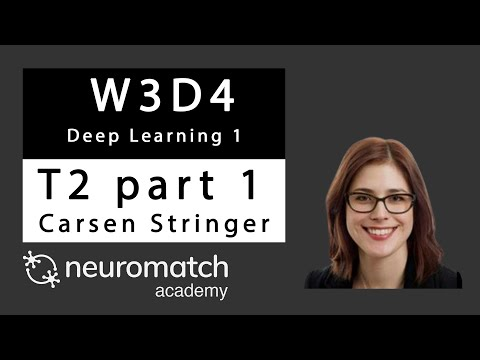

In [ ]:
#@title Video 1: Intro to convolutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="vPNu8CNg9i4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 1:

- build
an encoding model to try to understand
how neurons represent
different visual stimuli 
- network will take as input as stimulus
and output prediction for each of
these neurons activity 
- let's look at some of
this neural data
- in this case we split the
stimuli into two sets
train test and a test set
then we bin the stimuli in
bins of six degrees and average the
responses within that bin for each given
neuron 
- now that we've done the binning
you can look at these different neurons
tuning curves and
in some cases you can see two peaks in
response to these stimuli
in some cases maybe you see more than
two peaks 

- but in many of these cases it looks like
these tuning curves are the sum
of a few of these peaks at different
locations along this
stimulus orientation
dimension and in fact
a model such as this which is the sum of
a few filters along
a given dimension is called a
convolutional model 

- going to use a
deep network now with convolutions in
order to fit these neural responses

- convolution is the integral
of a product of two functions one of
which is our filter f
and our stimulus s which in this case we've created our stimulus such that
it's zero everywhere
except for one in the stimulus bin where
the stimulus
is that orientation
so if you want to perform a convolution
and get the same
output as the input you need to pad the
input by half the filter size on each
side

- next let's compute the output of the
convolution at each position
x along the stimulus dimension; 
and the size of its response after
performing this convolution is called
its activation

- so to compute a sub x we're going to
slide this filter
f along the stimulus s and compute the
sum of the product at each of these
points

- another parameter of this convolution
computation is the stride
and the stride is how often along the
stimulus to compute 

- we use a stride of
one; we have a different unit
for
every single position along the stimulus
axis x
but we could also use a stride of 10
where we'd have
fewer responses that are more spread out
here
and this can be advantageous in terms of
efficiency if you want to
reduce the amount of computation that
you have to do

- so now how do we compute this
computation
of this convolution so we can loop over
these positions
with some spacing which is the stride
and then at each of these positions x
we're going to take the
sum of the product of the filter and the
stimulus

- so how do we compute a convolution in pytorch?
create a convolutional layer which
which in this case takes as input a
stimulus

which looks like - zero
everywhere except for one
in the bin where the stimulus was active
now
this convolutional layer is initialized
with a few different parameters 
	- number of input channels
and in this case it's one because we
only have one
stimulus dimension here and then
	- number of convolutional channels 
we'll set the default value to eight and then the last one is the size of the
filter k which we set again to
to a default value which is nine 

-the input channels
=the number of output channels which is
=the number of convolutional channels

- create
the kernel size and then also the
padding which
again will set to the kernel size
over two
and then the stride will be one so now
input which is has a length of 60 we'll
get an output which is also a length of
60. 

- we're going to have to add the
singleton dimension which is adding this
one dimensional channel
which is the cn and then after we add
x through this convolutional layer and
get our output

- so why are convolutions good for
encoding models; 
in fact the brain itself
has a convolutional like architecture;
so in the retina there are a variety of
cell types which we can think of
as different filters and each of these
cells
tile the entire visual space 

- in barrel cortex we have a similar
situation where each of the whiskers
activations
corresponding to a
single cortical column of activity
and the functions computed in each of
these columns is similar

## Section 2.1: 1d convolution in numpy

We provide an example function below, described in the video, which performs a 1D convolution of a stimulus input $s$ with **filter** $f$ of size $K$ (these filters are also called *kernels*). In particular, it computes:

$$a_x = \sum^{K/2}_{i=-K/2} f_i \, s_{x-i}$$

where $a_x$ is the convolutional output at position $x$.

There is no exercise in this section but make sure you understand what is happening in the function below (i.e. what a convolution is). It can be helpful to write or draw this out on paper to clarify! You could even make your own short stimulus and filter and calculate what you think the convolutional output should be by hand, and then compare to the function output.

In [ ]:
def convolve1d(stimulus, f, pad, stride):
  """ Pads stimulus and performs 1d convolution

  Args:
    stimulus (ndarray): the 1D input for the convolution
    f (ndarray): the 1D filter for the convolution
    pad (scalar): the amount of zero padding for the stimulus
    stride (scalar): how far the filter moves every step

  Returns:
    (ndarray): convolutional output, same size as stimulus
  """

  # Pad the stimulus
  zero_pads = np.zeros(pad)
  padded_stimulus = np.concatenate((zero_pads, stimulus, zero_pads))

  # Initialize convolutional output
  a = np.nan * np.zeros(360)

  # Compute the convolution
  for x in np.arange(0+pad, 360+pad, stride, int): # loop over positions x

    # Compute element-wise multiplication between filter and stimulus
    a[x - pad] = (f * padded_stimulus[x-pad : x+pad]).sum()

  return a

In [ ]:
#@title
#@markdown Execute this cell to call convolve1d with a Gaussian filter and plot results

# Convolutional parameters
K = 49 # size of convolutional filter
stride = 1 # how often to compute the convolution along the stim axis
pad = K // 2 # we will need to pad stimulus with zeros to perform convolution

# Create stimulus
ori = 135
stimulus = np.zeros(360)
stimulus[ori] = 1.0

# Create Gaussian filter
# we will use the code from W2D1 (bayes day) to create this!
# mean of gaussian mu=0
i = np.arange(-pad, pad)
f = my_gaussian(i, 0.0, sigma=10)

# Call function
a = convolve1d(stimulus, f, pad, stride)

# Plot results
fig = plt.figure(figsize=(15,4))
plot_conv(pad, stimulus, f, a)
plt.show()

## Section 2.2: Convolutional layer

You have just learned how to compute what is called a single convolutional **channel**: a single filter applied to the input resulting in several units, where the number of units depends on the *stride* you set.

(Note if filter size *K* is odd and you set the *pad=K//2* and *stride=1* (as is the default above), you get a **channel** of units that is the same size as the input.)

*Contemplation:* How does a neuron potentially combine those activation units and create the tuning curves they have? Will we need more than one convolutional filter to recreate all the responses we see?



In [ ]:
# to_remove explanation

"""
We can think of all neurons being composed of the same shaped peak but at
different/multiple locations for each neuron. However, it appears that different
neurons have peaks that are shaped differently, or even the same neuron has two
peaks with different shapes. Therefore we may want multiple different convolutional
filters.
""";

Let's add more convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv1d()`, which requires the following arguments for initialization:
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters
  
When you run the network, you can input a stimulus of arbitrary length ($H^{in}$), but it needs to be shaped as a 2D input $C^{in} \times H^{in}$. In our case, $C^{in}=1$ because there is only one orientation input and $H^{in}$ is the number of stimulus bins $B$.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/convolutional_layer.PNG?raw=true" width="600" />
</p>

In [ ]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv1d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=8, K=9):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter

    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x h tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x h tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # n_stimuli x 1 x h, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer

    return a

### Exercise 1: 1D convolution in pytorch 

We will now run the convolutional layer on our stimulus. In particular, we will use the binary stimuli (`stim_binary`), which is a 60 x 60 tensor where each row contains the binary stimuli for one orientation (all zeros except for a one at that orientation). This tensor is size 60 instead of 360 because we have binned the orientations. Each row of this matrix is a different example orientation that we want to convolve - see cell below to visualize three rows of this tensor.



In [ ]:
# @markdown Execute this cell to visualize stim_binary
row_inds = [10, 25, 40]
fig = plt.figure(figsize=(15,4))

for j, row_ind in enumerate(row_inds):
  ax = fig.add_subplot(1, 3, j+1)
  ax.plot(np.arange(0, 60), stim_binary[row_ind,:], 'k')
  ax.set_title('stim_binary row '+str(row_ind))
  ax.set_xlabel('orientation bin')
  ax.set_ylabel('stimulus')

plt.show()

`nn.Conv1d` takes in a tensor of size $(N, C^{in}, H^{in}$) where $N$ is the number of examples, $C^{in}$ is the number of input channels, and $H^{in}$ is the number of stimulus bins $B$. Since our stimulus has only one input channel,  the `ConvolutionalLayer` class adds the $C^{in}$ dimension for us: we need to input an $(N, H^{in})$ stimulus, which `stim_binary` is!  


We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. In the plot, the activations for a single channel are shown in one color. 

In [ ]:
# Convolution layer parameters
K = 9 # filter size, now that we've binned let's make this smaller than for the numpy conv
conv_channels = 8 # how many convolutional channels to have in our layer

convout = np.zeros(0) # assign convolutional activations to convout

################################################################################
## TODO for students: compute convolution activations from stim_binary using pytorch
# Complete and uncomment
################################################################################

# Initialize conv layer
# convLayer = ConvolutionalLayer(...)

# Call conv layer on stimulus
# convout = convLayer(...)
# convout = convout.detach() # detach gradients
# print(convout.shape) # can you identify what each of these dimensions are?

# Plot results
# plot_example_activations(convout)

In [ ]:
# to_remove solution

# Convolution layer parameters
K = 9 # filter size, now that we've binned let's make this smaller than for the numpy conv
conv_channels = 8 # how many convolutional channels to have in our layer

convout = np.zeros(0) # assign convolutional activations to convout

# Initialize conv layer
convLayer = ConvolutionalLayer(c_in=1, c_out=conv_channels, K=K)

# Call conv layer on stimulus
convout = convLayer(stim_binary)
convout = convout.detach() # detach gradients
print(convout.shape) # can you identify what each of these dimensions are?

# Plot results
with plt.xkcd():
  plot_example_activations(convout)

#### Think!
  - Why are the convolutional activations for a given channel the same for many units?
  - What is the width of the non-constant activations (i.e. how many units in a given channel would differ from the constant)?
  - How many weights does this convLayer have? 
  - How many would it have if it were a fully connected layer? 

In [ ]:
# to_remove explanation

"""
1. As seen above, the stimulus is zero everywhere except for in one bin, and so
the convolutional activations are constant everywhere except for around the stimulus.
The constant offset is from a bias term that each convolutional channel has.
2. The width of non-constant activations is the kernel size K.
3. The convLayer has K*C_out weights.
4. A fully connected layer would have (B^2)*C_out weights.
""";

---
# Section 3: Encoding model using convolutions

Video available at https://youtube.com/watch?v=Me8X3Kro0EE


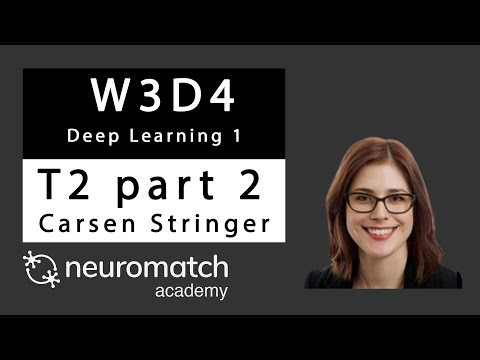

In [ ]:
#@title Video 2: Encoding model using convolutions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Me8X3Kro0EE", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 2:

- let's build our convolutional encoding model.
- put these
convolutions together with a fully connected layer and create an encoding model.
We input the stimulus which in this case has a dimensionality V and
we use a filter size of K
where K is 3 so it has three weights. And so now in this layer of
this network where we have this first channel of our convolutional layer,
we're going to compute the
activations. 

- eg: take S 2,
multiply it by W 1 1 and add that to as 3
times W 1 2 and add that to S 4 times W 1 3. And
then we can do this for a second unit
where we compute the multiplication of these 
inputs with these weights and we get our activation
H14. And then we can do the same thing when we add a second channel of weights
where we multiply these
 stimulus inputs by these weights

- for both these cases and we slide these down to compute our hidden unit activations. So
we get our hidden layer H is going to be W in,
which in this case are these weights for these different channels, convolved with our stimulus S,
plus some bias term B.  C out is a number of convolutional channels we have which in this case is 2, and so
the number of hidden units we have in total is going to be the number of convolutional channels we have
times the number of
stimulus bins we have, B, because we're using the same padding, so we get the same size
output as we give input.

- If this were a fully connected layer like the linear layers 
how many parameters would W have?
We have an input size B and we have B times C out
unit. So we had a fully connected linear layer. We would have B times B times C out
number of weights.

- So on the other hand in this convolutional layer, how many weights do we have? We have
K weights for each of our channels. So we have K times C out ways.

- And in most cases the number of parameters you need for the linear layer is much greater and it becomes even
substantially greater as the
dimensionality of your stimulus increases because the number of weights you need is B times B times C out which is B squared.
So now we found that using these convolutional models allows us to reduce the number of weights we need,
let's use these convolutional models to predict our neural responses. So we need to add to this convolutional layer - a fully connected layer
which we'll call the weights of this layer W out, and Y, which is our neural prediction, will be W out times H
plus B out.


## Section 3.1: Convolutional layer & fully connected layer

We will now build an encoding model by hooking this convolutional layer up to a fully connected layer, like the one that we used in Tutorial 1 (`nn.Linear`). We will use this model to predict neural responses.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/conv_fc.PNG?raw=true" width="800" />
</p>

This linear layer will have weights $W^{out}$ and we will get an output vector $\mathbf{y}$ of predicted neural responses.

### Exercise 2: Implement encoding model 

In this exercise, you will create the encoding model described above. In particular, you will:

* Add a fully connected layer to `__init__` method of network.
* Add a fully connected layer to `forward` method of network.

We will then train the network using the helper function `train`. Full training will take a few minutes: if you want to train for just a few steps to speed up the code while iterating on your code, you can decrease the `n_iter` input from 500.

In [ ]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer

  """

  def __init__(self, n_neurons, c_in=1, c_out=8, K=9, b=60):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, padding=K//2)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units

    ################################################################################
    ## TO DO for students: add fully connected layer to network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to initialize network")
    ################################################################################
    self.out_layer = nn.Linear(M, ...)

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli

    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x L, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer
    a = a.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector

    ################################################################################
    ## TO DO for students: add fully connected layer to forward pass of network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to network")
    ################################################################################
    y = ...

    return y


# Choose loss function
MSE_loss = nn.MSELoss()

## Initialize network
# net = ConvFC(n_neurons)

## Run GD on training set data
## ** this time we are also providing the test data to estimate the test loss
# train_loss, test_loss = train(net, MSE_loss, stim_binary, resp_train,
#                               test_data=stim_binary, test_labels=resp_test,
#                               n_iter=500, learning_rate=20)

## Plot the training loss over iterations of GD
# plot_training_curves(train_loss, test_loss)

In [ ]:
# to_remove solution
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer

  """

  def __init__(self, n_neurons, c_in=1, c_out=8, K=9, b=60):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv1d(c_in, c_out, kernel_size=K, padding=K//2)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units

    self.out_layer = nn.Linear(M, n_neurons)

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli

    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x L, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer
    a = a.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector

    y = self.out_layer(a)

    return y



# Choose loss function
MSE_loss = nn.MSELoss()

# Initialize network
net = ConvFC(n_neurons)

# Run GD on training set data
# ** this time we are also providing the test data to estimate the test loss
train_loss, test_loss = train(net, MSE_loss, stim_binary, resp_train,
                              test_data=stim_binary, test_labels=resp_test,
                              n_iter=500, learning_rate=20)

# Plot the training loss over iterations of GD
with plt.xkcd():
  plot_training_curves(train_loss, test_loss)

We trained this network to predict the neural responses -- see the yellow curve for the training loss. We also computed the test loss every 50 iterations. The training loss goes down throughout training but the testing loss doesn’t -- why is this? *We are overfitting to the NOISE in the training set.*

Let’s look at a prediction for a single neuron (below). The yellow curve is the training data, the pink curve is the testing data and the prediction is in green. You can barely see the yellow curve because the prediction has fit so well to the training data. However, some of what it has fit is noise. 

If we look at the weight matrix, we see that the weights are all positive or negative. Did we expect this to happen? Or did we think that this tuning curve is the sum of only a few filters and positions?



In [ ]:
# to_remove explanation

"""
We see many sharp peaks in the training set, but these peaks are not always present
in the test set, suggesting that they are due to noise. Therefore, ignoring this
noise, we might have expected the neural responses to be a sum of only a few
different filters and only at a few different positions. This would mean that we
would expect the `out_layer` weight matrix to be sparse, not dense like the one
shown here.
""";

In [ ]:
#@title
#@markdown Execute this cell to examine prediction for example neuron and see weights

# Input stimuli to network
y_pred = net(stim_binary)
print('output shape: ', y_pred.shape) # what are the two dimensions of this network output?

# Plot example neural response prediction and some fully-connected layer weights

# Look at the weights of the out_layer of the network
weights = net.out_layer.weight.detach()
print('output weights shape: ', weights.shape) # what are these two dimensions of the fully connected layer weights?

# Plot prediction + neuron + weights
neuron_index = np.random.choice(n_neurons)
plot_pred_weights(y_pred[:,neuron_index].detach(), resp_train[:,neuron_index],
                  resp_test[:,neuron_index], weights[:20])

*Comprehension check*: what does each dimension of the output and output weights correspond to?


In [ ]:
# to_remove explanation

"""
The output is shape 60 by 23589 where 60 is the number of stimulus bins and 23589
is the number of predicted neurons. The out_layer weights have shape 23589 by 480
where 23589 is the number of predicted neurons and 480 is the number of convolutional
units in the conv layer. There are 480 convolutional units because the stimulus
is length 60 and we used 8 $C^{out}$ convolutional channels.
""";

We can reduce overfitting using L2 regularization as we learned on W1D4. 

Additionally there is another type of regularization you might want... If we think of a neuron as a sum of a few convolutional filters, we might expect the weight matrix of the fully-connected layer to be sparse. Therefore, we can also apply an L1 regularization penalty to enforce sparsity. 



---
# (Bonus) Section 4: Regularization


Video available at https://youtube.com/watch?v=Qnn5OPHKo5w


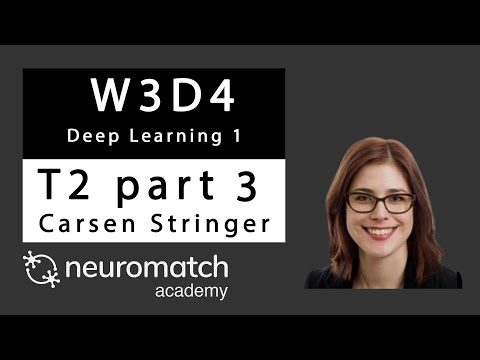

In [ ]:
#@title Video 3: Regularization
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Qnn5OPHKo5w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 3:

- We can also use regularization in deep networks to reduce overfitting
and in particular it's especially important in deep networks because deep networks can have millions of parameters.

- as a function of the number of operations that they perform vs as a function of their performance on imagenet.
=> each of these different networks is proportional to the number of parameters
that each of these networks has.

- You can use L1 and L2 regularization.
You can also use a technique called batch
normalization and this helps to keep your activations at a similar size and distribution across layers to improve optimization.
It's especially important if you have very deep networks.
We can also
use a technique called dropout which randomly removes units from the network during training
but this approach is not used so often anymore.

- And then finally, you can just reduce the number of parameters by using techniques like using convolutions. 

- So, how does L2 regularization work? So we have a cost function
 which is going to be our squared error loss term plus an additional term
which is a penalty on the norm of the weights.
And this prevents the weights from being large and potentially just being large to fit some noisy aspects of the training data.
So if we differentiate this cost function
we get the the first term which is our usual gradient of the loss function with respect to our weight W,
plus a a term that's two times lambda times the sum of the weights.
So for a given weight the update is going to be subtracting our original loss
gradient here,
plus subtracting the
term that's proportional to the weight itself.

- And so if the weight is positive you're going to subtract a positive value and push this weight towards zero.
Likewise if the weight is negative you're going to be subtracting a negative value, which is addition,
so you're going to be pushing that weight up so whether you're positive or negative
these weights are going to get shrunk to zero and that's why this type of regularization is called weight decay.

- And you can implement this in your optimizer
using weight decay parameter as an input, or you can opt you can
add it to your network manually
which is what we do in this case where we take the weights of our linear layer and we add this L2 penalty,
which is going to be squaring the weights and then summing them.

- L1 regularization adds a penalty which is the sum of the absolute value of the weights
and now this results in an update rule that only depends on the sign of the weight itself.
So this is going to be
larger than the weight decay penalty usually,
And it's only going to be zero when the weight is set to zero. Otherwise, it's going to be plus one or minus one.
So this means that L1 produces more sparse solutions, which in the case of the encoding models is useful because it's easier 
to interpret these models when they only have a few positive weights such as they're only adding a few different convolutional filters.
However, it can often be harder to optimize these types of functions.

- So L1 is producing these more sparse solutions where fewer weights are non-zero
whereas L2 is reducing the size of these weights.



As discussed in the lecture, it is often important to incorporate regularization terms into the loss function to avoid overfitting. In particular, in this case, we want to use these terms to enforce sparsity in the output layer. 

Here we'll consider the classic L2 regularization penalty $\mathcal{R}_{L2}$, which is the sum of squares of each weight in the network $\sum_{ij} {\mathbf{W}^{out}_{ij}}^2$ times a constant that we call `L2_penalty`.

We will also add an L1 regularization penalty $\mathcal{R}_{L1}$ to enforce sparsity of the weights, which is the sum of the absolute values of the weights $\sum_{ij} |{\mathbf{W}^{out}_{ij}}|$ times a constant that we call `L1_penalty`.

We will add both of these to the loss function:
\begin{equation}
    L = (y - \tilde{y})^2 + \mathcal{R}_{L2} + \mathcal{R}_{L1}
\end{equation}

The parameters `L2_penalty` and `L1_penalty` are inputs to the train function.

### (Bonus) Exercise 3: Add regularization to training 

We will create a new loss function that adds L1 and L2 regularization. 
In particular, you will:
* add L2 loss penalty to the weights 
* add L1 loss penalty to the weights


We will then train the network using this loss function. Full training will take a few minutes: if you want to train for just a few steps to speed up the code while iterating on your code, you can decrease the n_iter input from 500. 

Hint: since we are using `torch` instead of `np`, we will use `torch.abs` instead of `np.absolute`. You can use `torch.sum` or `.sum()` to sum over a tensor.





In [ ]:
def regularized_MSE_loss(output, target, weights=None, L2_penalty=0, L1_penalty=0):
  """loss function for MSE

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): fully-connected layer weights (net.out_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scalaing factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.MSELoss()
  loss = loss_fn(output, target)

  ##############################################################################
  # TO DO: add L1 and L2 regularization to the loss function and remove the error
  raise NotImplementedError("Student exercise: complete regularized_MSE_loss")
  ##############################################################################

  if weights is not None:
    L2 = L2_penalty * ...
    L1 = L1_penalty * ...
    loss += L1 + L2

  return loss

# Initialize network
net = ConvFC(n_neurons)

# Uncomment below to test your function

# Train network
# train_loss, test_loss = train(net, regularized_MSE_loss, stim_binary, resp_train,
#                               test_data=stim_binary, test_labels=resp_test,
#                               learning_rate=10, n_iter=500,
#                               L2_penalty=1e-4, L1_penalty=1e-6)

# Plot the training loss over iterations of GD
# plot_training_curves(train_loss, test_loss)

In [ ]:
# to_remove solution
def regularized_MSE_loss(output, target, weights=None, L2_penalty=0, L1_penalty=0):
  """loss function for MSE

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): fully-connected layer weights of network (net.out_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scalaing factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.MSELoss()
  loss = loss_fn(output, target)

  if weights is not None:
    L2 = L2_penalty * torch.square(weights).sum()
    L1 = L1_penalty * torch.abs(weights).sum()
    loss += L1 + L2

  return loss

# Initialize network
net = ConvFC(n_neurons)

# Train network
train_loss, test_loss = train(net, regularized_MSE_loss, stim_binary, resp_train,
                              test_data=stim_binary, test_labels=resp_test,
                              learning_rate=10, n_iter=500,
                              L2_penalty=1e-4, L1_penalty=1e-6)

# Plot the training loss over iterations of GD
with plt.xkcd():
  plot_training_curves(train_loss, test_loss)

If we now train the network with these regularization penalties we find that the train and test loss are similar throughout training: both continue decreasing.

We will now look at the predictions after using the regularized loss function. We can see below that the prediction is much smoother than before! This is because the weight matrix is in fact sparser (zero is represented by white in this color map)


In [ ]:
#@title
#@markdown Execute this cell to examine prediction for example neuron and see weights

# Plot prediction + neuron + weights
weights = net.out_layer.weight.detach()
y_pred = net(stim_binary)
neuron_index = np.random.choice(n_neurons)
plot_pred_weights(y_pred[:,neuron_index].detach(), resp_train[:,neuron_index],
                  resp_test[:,neuron_index], weights[:20])


Now let's look at what the predictions look like for many neurons

In [ ]:
#@title
#@markdown Execute this cell to examine predictions for random subsets of neurons

# Visualize tuning curves & plot neural predictions
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_prediction(ax, y_pred[:,ineur].detach(), resp_test[:,ineur])
  if k==0:
    ax.text(.1, 1., 'test', color='m', transform=ax.transAxes)
    ax.text(.1, .9, 'prediction', color='g', transform=ax.transAxes)

fig.tight_layout()
plt.show()

---
# Summary

In this notebook, we built and evaluated a neural network based encoding model to predict neural responses from stimuli. To do so we :
* implemented a basic convolution filter
* implemented and trained a convolutional neural network with multiple filters to predict neural responses using PyTorch
* learned about and implemented L2/L1 regularization to avoid overfitting

What can this tell us about the representation of oriented gratings in mouse visual cortex? Maybe we can think of interpreting each of the convolutional channels as a computation performed by a single group of neurons in thalamus, and each visual cortical neuron combines various groups of thalamic neurons. But we'd have to test hypotheses like these by, for instance, recording thalamic neurons.


Tutorial 3 is bonus, although we recommend watching the videos if possible!

---
# Appendix

Video available at https://youtube.com/watch?v=eU74NFroIHk


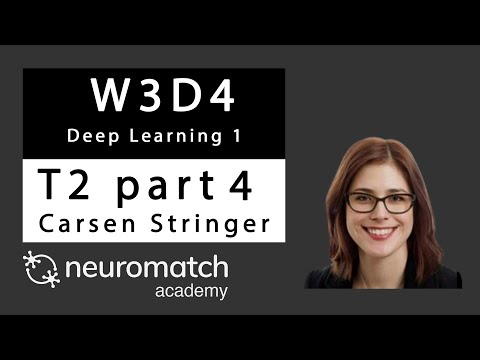

In [ ]:
#@title Video 4: Some practical advice for fitting neural networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="eU74NFroIHk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 4:

- You should always start off by training your neural network with only a few iterations,
and watching that progress before you let it run for hours and hours,
While you're watching this early progress, you can change various parameters in your training.
1. So you can add momentum (can be very helpful for optimization).
2. You can also vary the size of the random weights at initialization.
You can change the size of those weights and see how it potentially changes how well you can decrease
your L1 penalty - the sparsity penalty.
3. When you're trying to find the optimal learning rate,
	-an easy way to do it is to try to increase the learning rate as much as possible until the network explodes.
Then decrease it after that and just stay as close to that explosion point as possible
so that your learning rate is large and you're exploring a lot of the parameter space but not exploding.
	- Also other things people do as they can it they anneal the learning rate up at the beginning,
starting with a small learning rate and annealing up the first few epochs,
and then also you can anneal the learning rate down at the end, making it smaller as the epochs go on.
4. You can also decrease potentially the batch size
when you're running through the deep network.
5. You can look up more about stochastic gradient descent rather than gradient descent
which is particularly important when you have a really large data set. You can't run all those images at the same time. So you use batches.

myths:
1. Some people say bigger networks overfit more.
That can depend a lot on the architecture and whether or not you have for instance skip connections
or you're using residual networks.
2. Some people think that certain optimizers perform better like Adam or Adagrad.
You can try these different optimizers and see if they work better or worse for your specific problem.
3. People also say that stopping the optimization early is important.
And so that might be because you don't want to overfit too much to your test data.
But hopefully you have enough regularization in your network that that's not a problem.
4. Your test and your training loss decrease somewhat similarly across iterations.
In the past people often used dropout,
but it tends to be the case that batch normalization will work better for you.

## Why CNN's?

CNN models are particularly [well-suited](https://www.nature.com/articles/nn.4244) to modeling the visual system for a number of reasons:

1. **Distributed computation**: like any other neural network, CNN's use distributed representations to compute -- much like the brain seems to do. Such models, therefore, provide us with a vocabulary with which to talk and think about such distributed representations. Because we know the exact function the model is built to perform (e.g. orientation discrimination), we can analyze its internal representations with respect to this function and begin to interpret why the representations look the way they do. Most importantly, we can then use these insights to analyze the structure of neural representations observed in recorded population activity. We can qualitatively and quantitatively compare the representations we see in the model and in a given population of real neurons to hopefully tease out the computations it performs.

2. **Hierarchical architecture**: like in any other deep learning architecture, each layer of a deep CNN comprises a non-linear transformation of the previous layer. Thus, there is a natural hierarchy whereby layers closer to the network output represent increasingly more abstract information about the input image. For example, in a network trained to do object recognition, the early layers might represent information about edges in the image, whereas later layers closer to the output might represent various object categories. This resembles the [hierarchical structure of the visual system](https://pubmed.ncbi.nlm.nih.gov/1822724/), where [lower-level areas](https://www.jneurosci.org/content/25/46/10577.short) (e.g. retina, V1) represent visual features of the sensory input and [higher-level areas](https://www.sciencedirect.com/science/article/pii/S089662731200092X) (e.g. V4, IT) represent properties of objects in the visual scene. We can then naturally use a single CNN to model multiple visual areas, using early CNN layers to model lower-level visual areas and late CNN layers to model higher-level visual areas.
  
  Relative to fully connected networks, CNN's, in fact, have further hierarchical structure built-in through the max pooling layers. Recall that each output of a convolution + pooling block is the result of processing a local patch of the inputs to that block. If we stack such blocks in a sequence, then the outputs of each block will be sensitive to increasingly larger regions of the initial raw input to the network: an output from the first block is sensitive to a single patch of these inputs, corresponding to its "receptive field"; an output from the second block is sensitive to a patch of outputs from the first block, which together are sensitive to a larger patch of raw inputs comprising the union of their receptive fields. Receptive fields thus get larger for deeper layers (see [here](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) for a nice visual depiction of this). This resembles primate visual systems, where neurons in higher-level visual areas respond to stimuli in wider regions of the visual field than neurons in lower-level visual areas.

3. **Convolutional layers**: through the weight sharing constraint, the outputs of each channel of a convolutional layer process different parts of the input image in exactly the same way. This architectural constraint effectively builds into the network the assumption that objects in the world typically look the same regardless of where they are in space. This is useful for modeling the visual system for two (largely separate) reasons:
  * Firstly, this assumption is generally valid in mammalian visual systems, since mammals tend to view the same object from many perspectives. Two neurons at a similar hierarchy in the visual system with different receptive fields could thus end up receiving statistically similar synaptic inputs, so that the synaptic weights developed over time may end up being similar as well.
  * Secondly, this architecture significantly improves object recognition ability. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. Fully connected networks on their own can't achieve object recognition abilities anywhere close to human levels, making them bad models of human object recognition. Indeed, it is generally the case that [the better a neural network model is at object recognition, the closer the match between its representations and those observed in the brain](https://www.pnas.org/content/111/23/8619.short). That said, it is worth noting that our much simpler orientation discrimination task (in Tutorial 3) can be solved by relatively simple networks.